In [1]:
import pandas as pd
import numpy as np

In [3]:
# Import train and test data
test_candidates = pd.read_csv('test_candidates.csv')
train_candidates = pd.read_csv('train_candidates.csv')
train_true = pd.read_csv('train.csv')
train_true.head()

,left,right
0,aaa,osr
1,aaz,mqw
2,abh,cdx
3,abn,uzp
4,abq,bbd


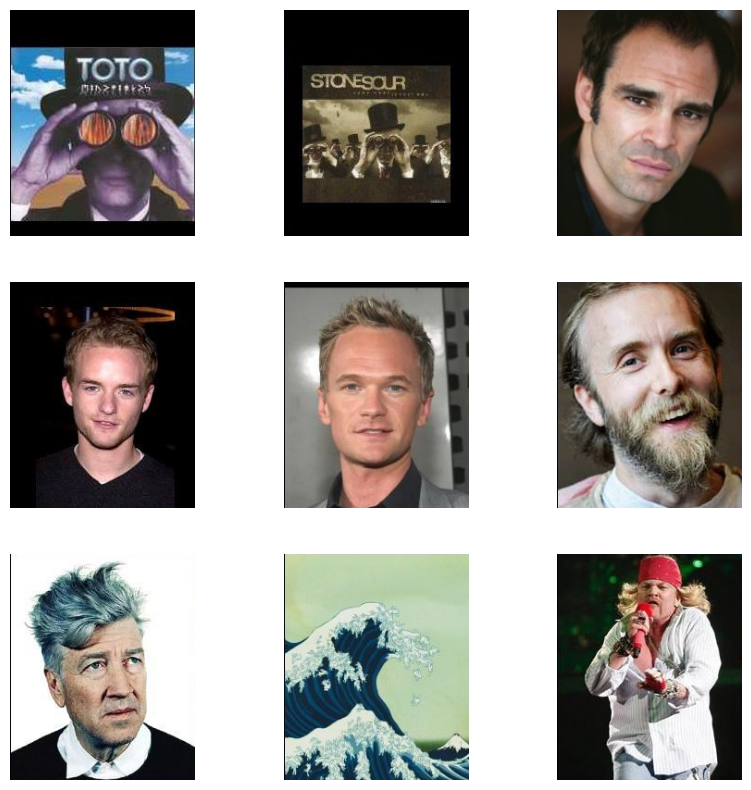

In [11]:
# Visualize some images from the training set
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
%matplotlib inline

def show(ax, fig, image_path):
    img = mpimg.imread(image_path)
    ax.imshow(img)
    ax.axis('off')

fig, axs = plt.subplots(3, 3, figsize=(10, 10))

for i in range(3):
    left, right = train_true.iloc[i]
    show(axs[i, 0], fig, 'train/left/{}.jpg'.format(left))
    show(axs[i, 1], fig, 'train/right/{}.jpg'.format(right))
    # random image from the train set (not a true match)
    rd_img = random.sample(list(train_candidates.iloc[i].where(lambda x: ~x.isin([left, right])).dropna()), 1)[0]
    show(axs[i, 2], fig, 'train/left/{}.jpg'.format(rd_img))

## Plan:
- Build feature extractor using pre-trained model (like ResNet 50)
- Build feature processor 

- Use a pre-trained model for feature extraction
- Extract features on 20 images from the train set
- Process images with pre-trained/homemade model
- Compute sine/cosine similarity matrix
- Select top 2 images most similar to 'left' image